# Backend part of Assigment I

Here you can find source code of scrapper, analisys, and work with database

## Scraper

First of all we need to obtain data. We will use **High-grossing films by year of release** table, since it contains the most number of films.

For parsing we will use **beautifull soup** and **Requests** libraries. It will provide all needed features and also it less complicated then **Scrapy**.

In [16]:
# Import of used libraries
import requests
from bs4 import BeautifulSoup
import csv
import re
from datetime import datetime

Information for each film contains in *infobox* table. To parce all data the following function will be used

In [19]:
def parse_infobox(url):
    """
    Parses the "infobox vevent" table from a Wikipedia page and extracts relevant movie details.
    :param url: Wikipedia page URL
    :return: Dictionary with extracted data
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the infobox table
    infobox = soup.find("table", class_="infobox vevent")
    if not infobox:
        print("Infobox not found!")
        return None
    
    data = {
        'year': None,
        'title': None,
        'director': None,
        'distributor': None,
        'country': None,
        'running_time': None,
        'budget': None,
        'box_office': None
    }
    
    # Function to clean text (removes references and extra spaces)
    def clean_text(text):
        text = re.sub(r'\[.*?\]', '', text)  # Remove references (e.g., [1], [2])
        text = text.replace('\n', ' ').strip()  # Remove new lines and extra spaces
        return text
    
    # Extract directed by
    row = infobox.find("th", string="Directed by")
    if row:
        data['director'] = clean_text(row.find_next("td").text)
    
    # Extract distributor
    row = infobox.find("th", string="Distributed by")
    if row:
        data['distributor'] = clean_text(row.find_next("td").text)
    
    # Extract country (first country if multiple present in ul element)
    row = infobox.find("th", string=re.compile("Country|Countries"))
    if row:
        country_td = row.find_next("td")
        if country_td.find("ul"):
            first_country = country_td.find("ul").find("li")
            if first_country:
                data['country'] = clean_text(first_country.text)
        else:
            data['country'] = clean_text(country_td.text.split(',')[0])
    
    # Extract running time (only integer part in minutes)
    row = infobox.find("th", string="Running time")
    if row:
        time_text = clean_text(row.find_next("td").text)
        time_match = re.search(r'(\d+)\s*minutes', time_text)
        if time_match:
            data['running_time'] = int(time_match.group(1))
        else:
            data['running_time'] = None
    
    # Extract budget (convert to millions)
    row = infobox.find("th", string="Budget")
    if row:
        data['budget'] = row.find_next("td").text
        value = re.search(r"\$[\d,.]*", data['budget']).group()[1:].replace(',', '')
        if re.search(r"(million)", data['budget']):
            value = int(float(value) * 1e6)
        data['budget'] = value
        

    # Extract box office revenue (convert to millions)
    row = infobox.find("th", string="Box office")
    if row:
        data['box_office'] = row.find_next("td").text
        value = re.search(r"\$[\d,.]*", data['box_office']).group()[1:].replace(',', '')
        if re.search(r"(million)", data['box_office']):
            value = int(float(value) * 1e6)
        elif re.search(r"(billion)", data['box_office']):
            value = int(float(value) * 1e9)
        data['box_office'] = value

    
    return data

Test our parce_infobox function. Note that 'year' and 'title' will be parced later, so it is fine if now there are None values

In [18]:
parse_infobox("https://en.wikipedia.org/wiki/You_Can%27t_Take_It_with_You_(film)")

{'year': None,
 'title': None,
 'director': 'Frank Capra',
 'distributor': 'Columbia Pictures',
 'country': 'United States',
 'running_time': 126,
 'budget': '1644736',
 'box_office': '2137575'}

Now define function that will parce our table. It iterates througth each row and extracts 'year', 'title', and 'url'. Url field is used to access dedicated films wiki page.

In [20]:
def parse_high_grossing_films(url):
    """
    Parses the second 'High-grossing films by year of release' table from a Wikipedia page,
    extracts the year and film href, and uses that data to call parse_infobox.
    Saves the collected data into a CSV file.
    :param url: Wikipedia page URL with the high-grossing films table
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    tables = soup.find_all("table", class_="wikitable plainrowheaders")
    
    table = tables[1]
    rows = table.find_all("tr")[1:]

    films = []

    for row in rows[:len(rows)-1]:
        if row.find("th") is None:
            continue
        href = row.find("td").find("a").attrs["href"]
        film_data = parse_infobox("https://en.wikipedia.org" + href)
        film_data["year"] = row.find("th").find("a").text
        film_data["title"] = row.find("td").find("a").text
        film_data["url"] = "https://en.wikipedia.org" + href
        print(film_data)
        films.append(film_data)

    return films


Allso, add function for saving our data to csv

In [55]:
def save_to_csv(film_data, filename="output/high_grossing_films.csv"):
    """
    Saves the extracted film data to a CSV file.
    :param film_data: List of dictionaries containing film details
    :param filename: Name of the output CSV file
    """
    with open(filename, "w", newline="") as file:
        fieldnames = ["year", "title", "director", "distributor", "country", "running_time", "budget", "box_office", "url"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for data in film_data:
            writer.writerow(data)
    
    print(f"Data saved to {filename}")


Now we can start our parcer. Note that sometimes that action will take long time, due to slow internet connection (or current moon phase :) )

In [22]:
url = "https://en.wikipedia.org/wiki/List_of_highest-grossing_films"
data = parse_high_grossing_films(url)

{'year': '1915', 'title': 'The Birth of a Nation', 'director': 'D. W. Griffith', 'distributor': 'Epoch Producing Co.', 'country': 'United States', 'running_time': 193, 'budget': '100000', 'box_office': 50000000, 'url': 'https://en.wikipedia.org/wiki/The_Birth_of_a_Nation'}
{'year': '1916', 'title': 'Intolerance', 'director': 'D. W. Griffith', 'distributor': 'Triangle Distributing Corporation', 'country': 'United States', 'running_time': 210, 'budget': '385907', 'box_office': 1750000, 'url': 'https://en.wikipedia.org/wiki/Intolerance_(film)'}
{'year': '1917', 'title': 'Cleopatra', 'director': 'J. Gordon Edwards', 'distributor': 'Fox Film Corporation', 'country': 'United States', 'running_time': None, 'budget': '250000', 'box_office': 1000000, 'url': 'https://en.wikipedia.org/wiki/Cleopatra_(1917_film)'}
{'year': '1918', 'title': 'Mickey', 'director': 'F. Richard JonesJames Young', 'distributor': 'States Rights Independent ExchangesFilm Booking Offices of America (FBO)', 'country': 'Unit

Now we just save all obtained data

In [23]:
save_to_csv(data)

Data saved to high_grossing_films.csv


## Data analisys

Ofcourse I will analise obtained data. **Pandas** dataframe will be used to store all data. Additionaly to plot graphs **Matplotlib** will be used.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read our data

In [54]:
df = pd.read_csv('output/high_grossing_films.csv')

Now we can look at our data little closer

The most expensive
Star Wars: The Force Awakens 447000000.0
Avengers: Endgame 356000000.0
Avatar: The Way of Water 350000000.0
Avengers: Infinity War 325000000.0
Pirates of the Caribbean: At World's End 300000000.0

Highest box office
Avatar 237000000.0
Avengers: Endgame 356000000.0
Avatar: The Way of Water 350000000.0
Titanic 200000000.0
Star Wars: The Force Awakens 447000000.0


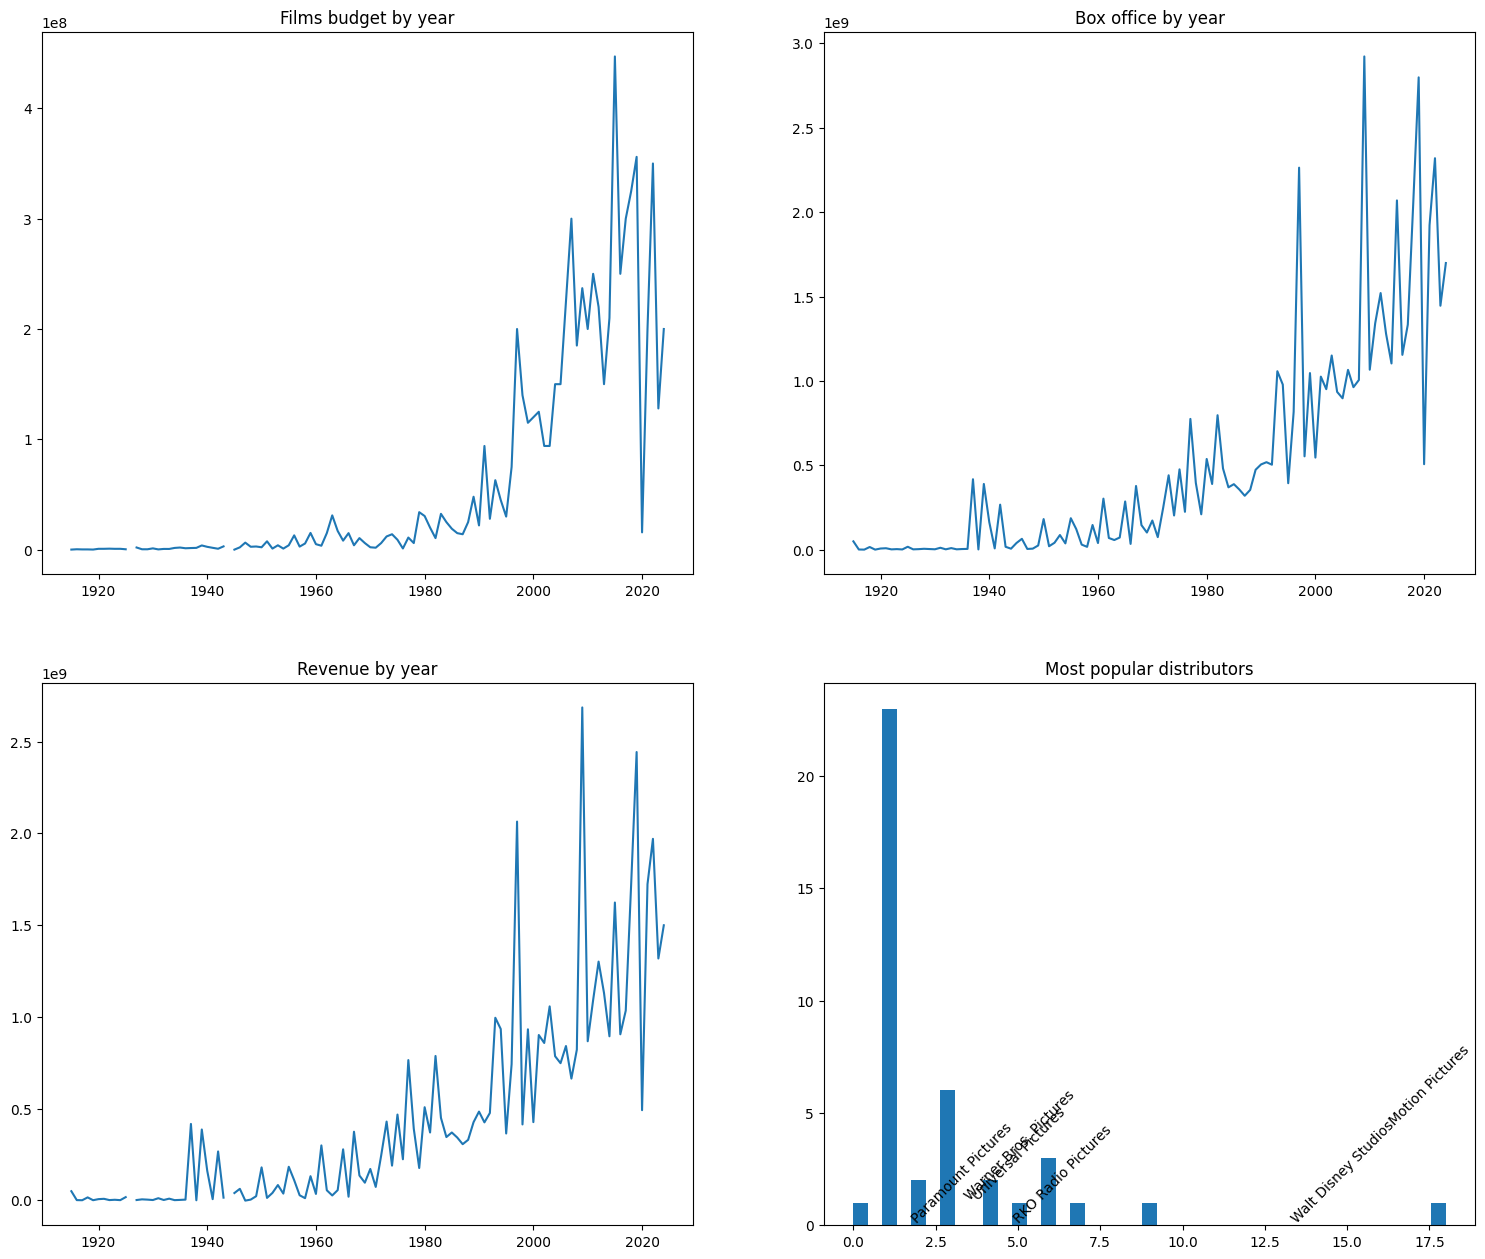

In [ ]:
years = np.array(df["year"].iloc[:])

fig, ax = plt.subplots(2, 2)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# Film budget by year
ax[0][0].set_title("Films budget by year")
ax[0][0].plot(years, np.array(df["budget"].iloc[:]))

# Box office by year
ax[0][1].set_title("Box office by year")
ax[0][1].plot(years, np.array(df["box_office"].iloc[:]))

# Revenue by year
ax[1][0].set_title("Revenue by year")
ax[1][0].plot(years, np.array(df["box_office"].iloc[:]) - np.array(df["budget"].iloc[:]))

# Most populae distributors
distributors = df["distributor"].unique()
ranks = {}
for distributor in distributors:
    ranks[distributor] = df[df["distributor"] == distributor]["distributor"].count()
ax[1][1].set_title("Most popular distributors")
ax[1][1].hist(ranks.values(), bins=len(distributors))

# Some stats
print("The most expensive")
for film in df.nlargest(5, ["budget"]).iloc[:].values:
    print(film[1], film[6])
print("\nHighest box office")
for film in df.nlargest(5, ["box_office"]).iloc[:].values:
    print(film[1], film[6])

Something is strange... Over here we have 1 misstake:

1921,The Four Horsemen of the Apocalypse,Rex Ingram,Metro Pictures,United States,134,800000000000,9200000,https://en.wikipedia.org/wiki/The_Four_Horsemen_of_the_Apocalypse_(film)

Here film cost is overestimated. What is why we need to analyse data.

After manualy fixing data we have the following:

In [ ]:
df.loc[6, 'budget'] = 800_000
df[df['year'] == 1921]

,year,title,director,distributor,country,running_time,budget,box_office,url
6,1921.0,The Four Horsemen of the Apocalypse,Rex Ingram,Metro Pictures,United States,134.0,800000.0,9200000.0,https://en.wikipedia.org/wiki/The_Four_Horseme...


The most expensive
Star Wars: The Force Awakens 447000000.0
Avengers: Endgame 356000000.0
Avatar: The Way of Water 350000000.0
Avengers: Infinity War 325000000.0
Pirates of the Caribbean: At World's End 300000000.0

Highest box office
Avatar 237000000.0
Avengers: Endgame 356000000.0
Avatar: The Way of Water 350000000.0
Titanic 200000000.0
Star Wars: The Force Awakens 447000000.0


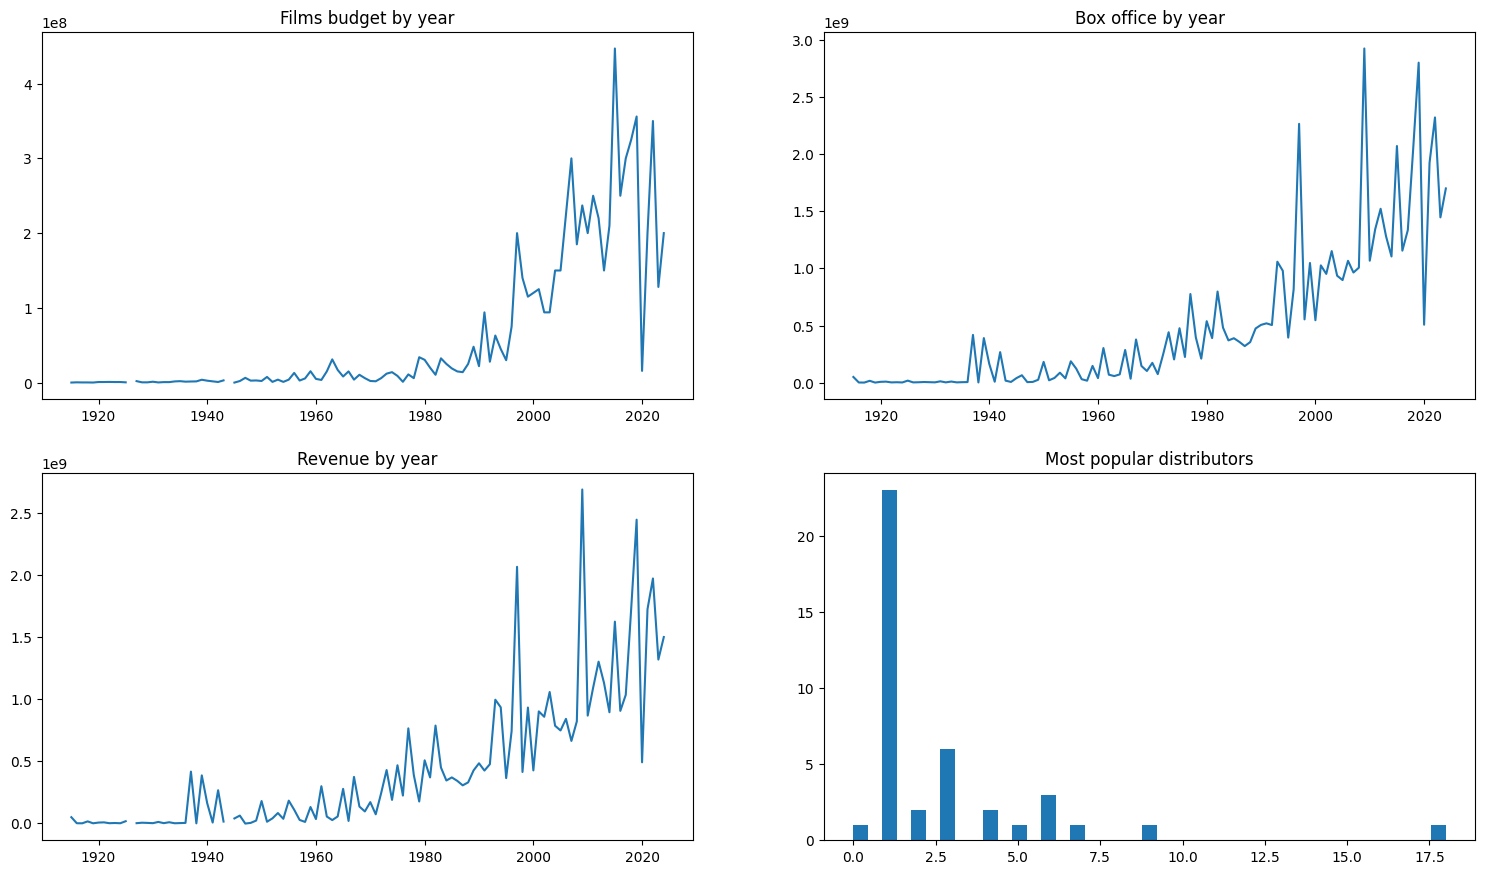

In [53]:
years = np.array(df["year"].iloc[:])

fig, ax = plt.subplots(2, 2)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# Film budget by year
ax[0][0].set_title("Films budget by year")
ax[0][0].plot(years, np.array(df["budget"].iloc[:]))

# Box office by year
ax[0][1].set_title("Box office by year")
ax[0][1].plot(years, np.array(df["box_office"].iloc[:]))

# Revenue by year
ax[1][0].set_title("Revenue by year")
ax[1][0].plot(years, np.array(df["box_office"].iloc[:]) - np.array(df["budget"].iloc[:]))

# Most populae distributors
distributors = df["distributor"].unique()
ranks = {}
for distributor in distributors:
    ranks[distributor] = df[df["distributor"] == distributor]["distributor"].count()
ax[1][1].set_title("Most popular distributors")
ax[1][1].hist(ranks.values(), bins=len(distributors))

# Some stats
print("The most expensive")
for film in df.nlargest(5, ["budget"]).iloc[:].values:
    print(film[1], film[6])
print("\nHighest box office")
for film in df.nlargest(5, ["box_office"]).iloc[:].values:
    print(film[1], film[6])

Now everything is correct. Note that there .csv file must be fixed by hand

## Database

Now lets push all our data to database. We will use **Docker** to setup container with **Postgres DB**.



In [ ]:
docker run --name dwv_pg -p 5432:5432 -e POSTGRES_USER=<user_here> -e POSTGRES_PASSWORD=<password_here> -e POSTGRES_DB=<db_name> -d postgres

Now we have our database up. For connection we will use **PsycoPG2** library. Note that all database credentials must be stored in .env file:




In [38]:
import psycopg2
import os
from dotenv import load_dotenv

In [ ]:
load_dotenv()

db_params = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
}
db_params

Now insert all data in our database

In [ ]:
df = pd.read_csv('output/high_grossing_films.csv')

# Connect to PostgreSQL and insert data
with psycopg2.connect(**db_params) as conn:
    with conn.cursor() as cur:
        for _, row in df.iterrows():
            cur.execute("""
                INSERT INTO movies (year, title, director, distributor, country, running_time, budget, box_office, url)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
            """, (row["year"], row["title"], row["director"], row["distributor"],
                  row["country"], row["running_time"], row["budget"], row["box_office"], row["url"]))
        conn.commit()
        print("Data inserted successfully!")

Data inserted successfully!


## For GitHub Pages

Since GitHub Pages cannot work with databases, all data must be stored in .json file

In [56]:
import csv
import json

def csv_to_json(csv_file, json_file):
    data = []
    
    with open(csv_file, mode='r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            data.append(row)
    
    with open(json_file, mode='w', encoding='utf-8') as file:
        json.dump(data, file, indent=4)
    
    print(f"CSV file '{csv_file}' successfully converted to JSON file '{json_file}'")

# Example usage
csv_to_json('output/high_grossing_films.csv', 'output/data.json')


CSV file 'output/high_grossing_films.csv' successfully converted to JSON file 'output/data.json'
